Current TODO:
- Decide if we are happy with the results
    - They are very different from the values given by graphworld
    - Since GraphWorld's paper they have introduced min_deg which may be weird / influencing the degree distribution
    - num_clusters and min_degree are very low. Are we happy with having a binary classification problem as default? 
    - It may not be intended by GraphWorld, but their integer sampling is not inclusive, hence when we have sampled results for num_clusters from [2-6] then we have really only gotten from [2-5]   
- Discuss biases:
    - Taking the bin with the largest average can be biased if one property produces an extremely large value while the remaining properties produce small values (see results for avg_deg)
    - Certain models may affect the results, as for each graph we examine the average test metric across all methods. If 1 method behaves produces extreme values while the remaining only differ very little, then the models with extreme values will have a larger influence in our results

In [1]:
import pandas as pd
import json
from evaluation_utils import read_processed_shards, get_best_configuration_per_model
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
from matplotlib.ticker import PercentFormatter
from scipy.stats import f_oneway
from tqdm import tqdm
from collections import defaultdict
import scipy

In [2]:
PROCESSED_DIR = f'results/mode1/processed'
df = read_processed_shards(PROCESSED_DIR)

1.ndjson
2.ndjson
3.ndjson
4.ndjson
5.ndjson
6.ndjson
7.ndjson
concatenating


In [5]:
# Remove graphs where at least one method have failed
df.drop(['marginal_param', 'fixed_params'], axis=1, inplace=True)
df.dropna(axis=0, inplace=True)

KeyError: "['marginal_param', 'fixed_params'] not found in axis"

### Computing default graph properties given all experiments

In [14]:
# Compute average test metric for each graph
TEST_METRIC = 'test_rocauc_ovr'
cols = [col for col in df.columns if TEST_METRIC in col]
df[f'avg_{TEST_METRIC}'] = df[cols].mean(axis=1)

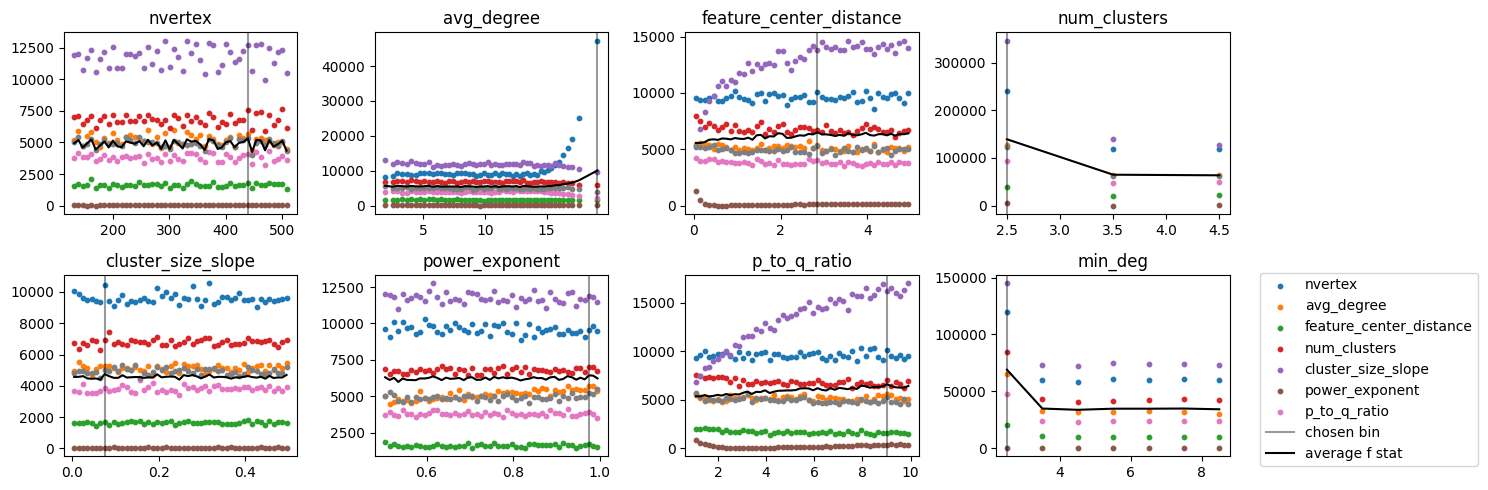

Optimal nvertex bin: (435.0, 443.0]
Optimal avg_degree bin: (17.935, 20.289]
Optimal feature_center_distance bin: (2.798, 2.901]
Optimal num_clusters bin: (1.999, 3.0]
Optimal cluster_size_slope bin: (0.07, 0.0801]
Optimal power_exponent bin: (0.97, 0.98]
Optimal p_to_q_ratio bin: (8.932, 9.11]
Optimal min_deg bin: (1.999, 3.0]


In [7]:
# ---------------- SETUP ----------------
# Bin each graph property into a fixed number of quantile bines
GRAPH_PROPERTIES = ['nvertex', 'avg_degree', 'feature_center_distance', 'num_clusters',
                    'cluster_size_slope', 'power_exponent', 'p_to_q_ratio', 'min_deg']
BINS = 50
for gp in GRAPH_PROPERTIES:
    bins = pd.qcut(df[gp], q=BINS, duplicates='drop')
    df[f'bin_{gp}'] = bins

# create an empty dictionary to store the results
results = {}

# Plotting setup
colors = {}
for i, gp in enumerate(GRAPH_PROPERTIES):
    colors[gp] = plt.cm.tab10(i)

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(15,5))



# ---------------- EXECUTION ----------------
# loop over each graph property
for gp, ax in zip(GRAPH_PROPERTIES, axs.reshape(-1)):
    bin_f_stats = {}
    plotting_f_stats = defaultdict(list)
    bins = sorted(df[f'bin_{gp}'].unique())

    # loop over each quantile bin of the property
    for b in bins:
        # filter the dataframe to only include rows where the current parameter is in bin i
        df_i = df[df[f'bin_{gp}'] == b]
        test_metric = df_i[f'avg_{TEST_METRIC}']

        # compute the average F statistic between the other parameters and the test metric
        f_stats = []
        for gp_other in GRAPH_PROPERTIES:
            if gp_other != gp:
                f_stat, p_val = f_oneway(df_i[gp_other], test_metric)
                f_stats.append(f_stat)
                plotting_f_stats[gp_other].append(f_stat)        
        bin_f_stats[b] = sum(f_stats) / len(f_stats)

    # find the quantized value that produced the highest average F statistic
    max_f_stat = max(bin_f_stats, key=bin_f_stats.get)
    results[gp] = max_f_stat

    # plotting
    for k,v in plotting_f_stats.items():
        ax.scatter([b.mid for b in bins], v, color=colors[k], label=k, s=10)
    ax.axvline(x = max_f_stat.mid, color = 'black', alpha=0.4, label = 'chosen bin')
    ax.plot([b.mid for b in bins], [f for f in bin_f_stats.values()], color='black', label="average f stat")
    ax.title.set_text(gp)
axs[-1][-1].legend(bbox_to_anchor=(1.1, 1.05))
fig.tight_layout()
plt.show()
        
for k,v in results.items():
    print(f'Optimal {k} bin: {v}')


### Computing default graph properties given experiments on best configurations
Ignore this section this is TODO

In [15]:
# Compute average test metric for each graph
TEST_METRIC = 'test_rocauc_ovr'
df.drop([f'avg_{TEST_METRIC}'], axis=1, inplace=True)
best_configurations = get_best_configuration_per_model(df, TEST_METRIC)

In [16]:
for model, configuration in best_configurations.items():
    configuration.drop([f'{model}_{TEST_METRIC}'], axis=1, inplace=True)
    ad = 2

<string>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


In [ ]:
# ---------------- SETUP ----------------
# Bin each graph property into a fixed number of quantile bines
GRAPH_PROPERTIES = ['nvertex', 'avg_degree', 'feature_center_distance', 'num_clusters',
                    'cluster_size_slope', 'power_exponent', 'p_to_q_ratio', 'min_deg']
BINS = 50
for gp in GRAPH_PROPERTIES:
    bins = pd.qcut(df[gp], q=BINS, duplicates='drop')
    df[f'bin_{gp}'] = bins

# create an empty dictionary to store the results
results = {}

# Plotting setup
colors = {}
for i, gp in enumerate(GRAPH_PROPERTIES):
    colors[gp] = plt.cm.tab10(i)

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(15,5))



# ---------------- EXECUTION ----------------
# loop over each graph property
for gp, ax in zip(GRAPH_PROPERTIES, axs.reshape(-1)):
    bin_f_stats = {}
    plotting_f_stats = defaultdict(list)
    bins = sorted(df[f'bin_{gp}'].unique())

    # loop over each quantile bin of the property
    for b in bins:
        # filter the dataframe to only include rows where the current parameter is in bin i
        df_i = df[df[f'bin_{gp}'] == b]
        test_metric = df_i[f'avg_{TEST_METRIC}']

        # compute the average F statistic between the other parameters and the test metric
        f_stats = []
        for gp_other in GRAPH_PROPERTIES:
            if gp_other != gp:
                f_stat, p_val = f_oneway(df_i[gp_other], test_metric)
                f_stats.append(f_stat)
                plotting_f_stats[gp_other].append(f_stat)        
        bin_f_stats[b] = sum(f_stats) / len(f_stats)

    # find the quantized value that produced the highest average F statistic
    max_f_stat = max(bin_f_stats, key=bin_f_stats.get)
    results[gp] = max_f_stat

    # plotting
    for k,v in plotting_f_stats.items():
        ax.scatter([b.mid for b in bins], v, color=colors[k], label=k, s=10)
    ax.axvline(x = max_f_stat.mid, color = 'black', alpha=0.4, label = 'chosen bin')
    ax.plot([b.mid for b in bins], [f for f in bin_f_stats.values()], color='black', label="average f stat")
    ax.title.set_text(gp)
axs[-1][-1].legend(bbox_to_anchor=(1.1, 1.05))
fig.tight_layout()
plt.show()
        
for k,v in results.items():
    print(f'Optimal {k} bin: {v}')
